In [1]:
import pickle
import torch

# Specify the path to your pickle file
pickle_file_path = 'results/11-9-14:38:47.config.pkl'
    
# Load the pickle file
with open(pickle_file_path, 'rb') as file:
    config = pickle.load(file)

from CellPLM.model import OmicsFormer

model = OmicsFormer(**config)

config['projection'] = False

path = '/data/civy/integration/11-9-14:42:40_with_token_test.pt'

model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [9]:
import scanpy as sc
from scipy import  sparse

import torch

data = sc.read_h5ad('2000.h5ad')
if 'platform' not in data.obs:
    data.obs['platform'] = 'scRNA-seq'
if 'Dataset' not in data.obs:
    data.obs['Dataset'] = data.obs['study']
if 'batch_label' in data.obs:
    data.obs['batch'] = data.obs['batch_label']
gene_list = data.var.index.to_list()
gene_dict = dict(zip(data.obs['Dataset'].unique(), [torch.ones(len(gene_list)).bool()] * data.obs['Dataset'].nunique()))
ndataset = data.obs['Dataset'].nunique()


from CellPLM.utils.data import XDict, clean_batches, balanced_partition, data_setup

seq_list, batch_list, batch_labels, order_list, dataset_list, coord_list, label_list = data_setup(data, return_sparse=True)

partitions = balanced_partition(batch_list, 1)

In [10]:
import torch.nn as nn 
from torch.nn import  functional as F



class new_encoder(nn.Module):
    def __init__(self, encoder):
        super(new_encoder, self).__init__()
        
        self.__dict__.update(encoder.__dict__)  
        

    def forward(self, x_dict, output_attentions=False):
        h = x_dict['h']
        att_list = []
        for l in range(self.num_layers):

            if l == 0:
                x_dict['base0'] = h.detach()
            if output_attentions:
                h, att = self.layers[l](h, output_attentions=True)
                #print(att.shape)
                att_list.append(att)
            else:
                h = self.layers[l](h)
            if l == 0:
                x_dict['base1'] = h.detach()

        if False:
            return h
        else:
            return h

class Igwrapper(nn.Module):
    def __init__(self, model):
        super(Igwrapper, self).__init__()
        self.model = model
        self.encoder = new_encoder(model.encoder)
    def forward(self, x, batch, coord, gene_mask, dataset):
        x_dict = XDict({'x_seq': x.cuda(),  # seq_list[i].cuda(rank),
                        'batch': batch.cuda(),
                        'coord': coord.cuda(),
                        'gene_mask': gene_mask.cuda(),
                         'dataset': dataset.cuda(),
                        })
        x_dict['h'] = self.model.embedder(x_dict, None)
        if self.model.reg_token is not None:
            x_dict['h'] = torch.cat([x_dict['h'], self.model.reg_token])
        x_dict['h'] = self.encoder(x_dict, False)
        x_dict['h'] = x_dict['h'][:-8]
 
        x_dict['h'], latent_loss = self.model.latent(x_dict)
        if self.model.head_type is not None:
            out_dict, loss = self.model.head(x_dict)
            out_dict['latent_loss'] = latent_loss.item() if torch.is_tensor(latent_loss) else latent_loss
            out_dict['target_loss'] = loss.item()
        else:
            out_dict = self.model.decoder(x_dict)
        return out_dict['recon']
    def get_rep(self, x_dict):
        x_dict['h'] = self.model.embedder(x_dict, None)
        if self.model.reg_token is not None:
            x_dict['h'] = torch.cat([x_dict['h'], self.model.reg_token])
        x_dict['h'] = self.encoder(x_dict, False)
        return  x_dict['h'][-8:]
        


import torch.nn as nn 
from torch.nn import  functional as F

class Encoderwrapper(nn.Module):
    def __init__(self, model):
        super(Encoderwrapper, self).__init__()
        self.model = model
    def forward(self, x, batch, coord, gene_mask, dataset):
        x_dict = XDict({'x_seq': x.cuda(),  # seq_list[i].cuda(rank),
                        'batch': batch.cuda(),
                        'coord': coord.cuda(),
                        'gene_mask': gene_mask.cuda(),
                         'dataset': dataset.cuda(),
                        })
        x_dict['h'] = self.model.embedder(x_dict, None)
        if self.model.reg_token is not None:
            x_dict['h'] = torch.cat([x_dict['h'], self.model.reg_token])
        x_dict['h'] = self.model.encoder(x_dict, False)['hidden']
        #print(x_dict['h'].shape)
        if self.model.reg_token is not None:
            x_dict['h'] = x_dict['h'][:-8]
        x_dict['h'], latent_loss = self.model.latent(x_dict)
        return x_dict['h']

In [11]:
from CellPLM.utils.eval import minimum_eval, clustering_eval, CountCorr
import anndata as ad
import pandas as pd 
import hdf5plugin
import torch



model.cuda(0)
model.eval()

net = Igwrapper(model)


c = []
res = []
with torch.no_grad():
    for i in range(len(batch_list)):
        x = torch.sparse_csr_tensor(seq_list[0][i], seq_list[1][i],
                                seq_list[2][i],
                                seq_list[3][i].tolist()).to_sparse().float().coalesce()
        x_dict = XDict({'x_seq': x.cuda(),  # seq_list[i].cuda(rank),
                        'batch': batch_list[i].cuda(),
                        'coord': coord_list[i].cuda(),
                        'gene_mask': torch.ones([x.shape[1]]).bool().cuda(),
                         'dataset': dataset_list[i].cuda(),
                        })
        y = x_dict['x_seq'].to_dense()
        rep = net.get_rep(x_dict)
        res.append(rep.cpu().unsqueeze(0))
        
torch.cuda.empty_cache()

batch_rep = torch.cat(res, dim=0).numpy()

In [12]:

from sklearn.preprocessing import LabelEncoder
import numpy as np

lb = LabelEncoder().fit(data.obs['batch'])

batch_labels = lb.inverse_transform(np.arange(len(batch_list)))
dataframe = {}
for name in data.obs:
    ty = 0
    value = []
    for i in range(len(batch_list)):
        ty += np.unique(data.obs[name][data.obs['batch'] == batch_labels[i]].values).shape[0]
        value.append(data.obs[name][data.obs['batch'] == batch_labels[i]].values[0])
    if ty == 166:
        dataframe[name] = value

In [13]:
batch_obs = pd.DataFrame(dataframe)

In [14]:
mean_exp = []

for i in range(len(batch_list)):
    x = torch.sparse_csr_tensor(seq_list[0][i], seq_list[1][i],
                            seq_list[2][i],
                            seq_list[3][i].tolist()).to_sparse().float().coalesce()
    mean_exp.append(x.to_dense().mean(axis=0))

In [15]:
import numpy as np

batch_adata = ad.AnnData(X=torch.stack(mean_exp).cpu().numpy(), obs=batch_obs)

batch_adata.obsm['reg_token'] = batch_rep

batch_adata.obs['dataset'] = batch_adata.obs['dataset'].astype('category')

batch_adata.obsm['reg_token_mean'] = batch_rep.mean(axis=1)


/data/civy/miniconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/data/civy/miniconda3/lib/python3.10/site-packages/umap_learn-0.5.3-py3.10.egg/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/data/civy/miniconda3/lib/python3.10/site-packages/umap_learn-0.5.3-py3.10.egg/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/data/civy/miniconda3/lib/python3.10/sit

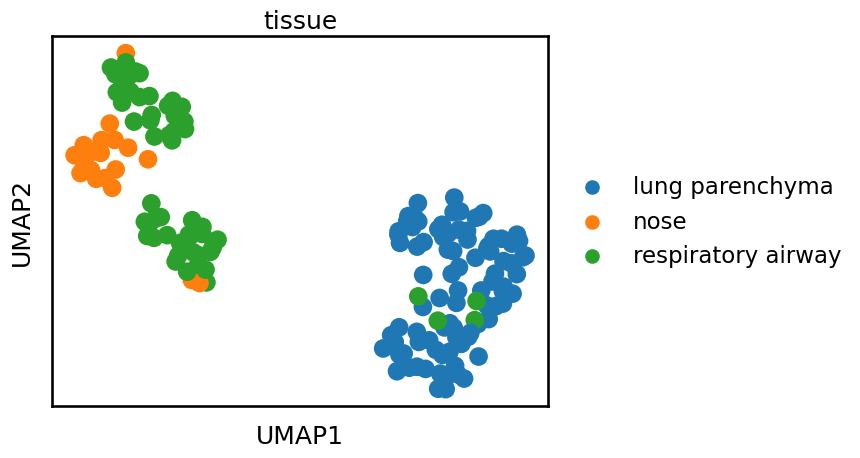

In [16]:
import scanpy as sc 

sc.pp.neighbors(batch_adata, use_rep='reg_token_mean')
sc.tl.umap(batch_adata)

sc.pl.umap(batch_adata, color=['tissue'])


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from scipy.optimize import curve_fit
import scanpy as sc
import anndata
from scipy.stats import wasserstein_distance


def linear_func(x, m, c):
    """Linear function"""
    return m * x + c

def calculate_distance(x, y, m, c):
    """Calculate the perpendicular distance between data points and the fitted curve"""
    return np.abs((m * x - y + c)) / np.sqrt(m ** 2 + 1)

def draw_scatter_with_correlation(x, y, save_path=None):
    """
    Draw scatter plot of data points along with the fitted curve, correlation coefficients, and p-values.

    Args:
        x (ndarray): Input x data points.
        y (ndarray): Input y data points.
    """
    # Perform curve fitting
    popt, pcov = curve_fit(linear_func, x, y)
    m, c = popt

    # Calculate Pearson correlation coefficient and p-value
    pearson_corr, pearson_pval = pearsonr(x, y)

    # Calculate Spearman correlation coefficient and p-value
    spearman_corr, spearman_pval = spearmanr(x, y)

    # Calculate the distances of data points from the fitted curve
    distances = calculate_distance(x, y, m, c)

    # Normalize distances to the range [0, 1]
    norm_distances = (distances - np.min(distances)) / (np.max(distances) - np.min(distances))

    # Create scatter plot
    fig, ax = plt.subplots()
    ax.scatter(x, y, c=norm_distances, cmap='gray', alpha=0.8, label='_nolegend_')

    # Plot the fitted curve
    x_fit = np.linspace(np.min(x), np.max(x), 100)
    y_fit = linear_func(x_fit, m, c)
    ax.plot(x_fit, y_fit, color='black', label='_nolegend_')

    # Add correlation coefficients and p-values to the plot
    corr_text = f"Pearson Corr: {pearson_corr:.2f} (p-value: {pearson_pval:.2e})\nSpearman Corr: {spearman_corr:.2f} (p-value: {spearman_pval:.2e})"
    ax.text(0.95, 0.95, corr_text, transform=ax.transAxes, verticalalignment='top', horizontalalignment='right')

    # Set axis labels and legend
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    #ax.legend()

    plt.show()
    if save_path:
        plt.savefig(save_path)
    
    plt.close()
    
    return pearson_corr, spearman_corr


def draw_umap_3d(data, save_path=None, figsize=(20, 20)):
    """
    Generate a 3D UMAP figure for the given data.

    Args:
        data (ndarray): The input data to be visualized.
        save_path (str, optional): Path to save the figure as an image file. Defaults to None.
        figsize (tuple, optional): Figure size in inches (width, height). Defaults to (8, 8).
    """
    # Apply UMAP with 3 dimensions
    umap_model = umap.UMAP(n_components=3)
    umap_embeddings = umap_model.fit_transform(data)

    # Create a 3D plot with custom figure size
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    # Generate a color map based on the index values
    indices = np.arange(len(data))
    colors = plt.cm.get_cmap('viridis', len(indices))

    # Plot the data points with colors based on index
    scatter = ax.scatter(
        umap_embeddings[:, 0],
        umap_embeddings[:, 1],
        umap_embeddings[:, 2],
        c=indices,
        cmap=colors,
        marker='o',
        s=250
    )

    # Customize the figure
    ax.set_xlabel('UMAP Dimension 1')
    ax.set_ylabel('UMAP Dimension 2')
    ax.set_zlabel('UMAP Dimension 3')
    ax.set_title('3D UMAP')

    cbar = plt.colorbar(scatter, shrink=0.6)
    cbar.set_label('Index')
    # Adjust spacing around the plot
    plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9)

    # Save the figure if save_path is provided
    plt.show()

In [18]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pc1_reg = pca.fit_transform(batch_adata.obsm['reg_token_mean'])



pca = PCA(n_components=2)
pc1_mean = pca.fit_transform(batch_adata.X)


batch_adata.obs['stage'] = lb.fit_transform(batch_adata.obs['development_stage'])

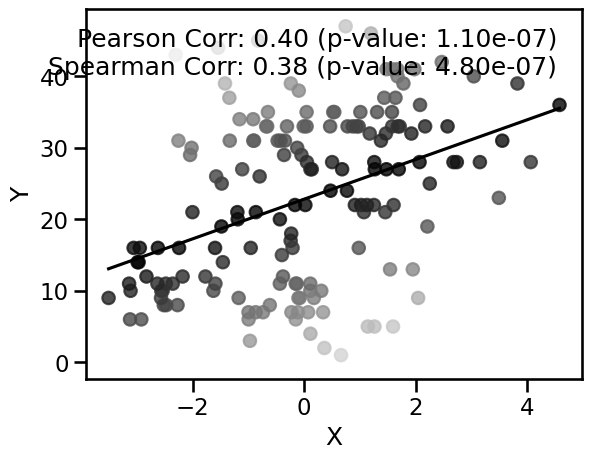

(0.39796081216025864, 0.37893127207293925)

In [19]:

draw_scatter_with_correlation(pc1_reg[...,1], batch_adata.obs['stage'].values)

In [ ]:
from sklearn.linear_model import  LogisticRegression
from sklearn.
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = batch_adata.obsm['reg_token_mean']

y =batch_adata.obs['sex']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LogisticRegression(random_state=42)

lr.fit(X_train, y_train)
logistic_predictions = lr.predict(X_test)
logistic_accuracy = accuracy_score(y_test, logistic_predictions)
print(f"Logistic Regression accuracy: {logistic_accuracy}")

X = batch_adata.X

y = batch_adata.obs['sex']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LogisticRegression(random_state=42)

lr.fit(X_train, y_train)
logistic_predictions = lr.predict(X_test)
logistic_accuracy = accuracy_score(y_test, logistic_predictions)
print(f"Logistic Regression accuracy: {logistic_accuracy}")